In [1]:
import numpy as np
from IPython.display import *
%pylab inline
import matplotlib.pyplot as plt
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
E_rel = 1e-4
E_abs = 1e-4

In [3]:
def eps(y_n, y_n1 = 0):
    return E_abs + E_rel*(np.abs(y_n) + np.abs(y_n1))/2.

In [4]:
def err(y_n, y_n1, yd_n1):
    d = y_n.size
    v = (y_n1 - yd_n1)/eps(y_n, y_n1)
    return np.sqrt((v*v).sum() / d)

In [5]:
factor_min = 0.1
factor_max = 5
factor = 0.9
h_min = 1e-4

In [6]:
def h_opt(q, err_h, h):
    return max(h_min,
               h*min(factor_max,
                     max(factor_min,
                         factor*np.power(1./err_h, 1./(q+1)))))

In [7]:
def norm(y0, y):
    eps_0 = E_abs + np.abs(y0)*E_rel
    v = y/eps_0
    d = y.size
    return np.sqrt((v*v).sum()/d)

In [8]:
def starting_h(p, f, x0, y0):
    d0 = norm(y0, y0)
    v0 = f(x0, y0)
    d1 = norm(y0, v0)
    h0 = 0.01 * d0/d1
    y1 = y0 + h0*v0
    v1 = f(x0+h0, y1)
    d2 = norm(y0, v1 - v0) / h0
    d_max = max(d1,d2)
    h1 = np.power(0.01/d_max, 1/(p+1))
    if d_max < 1e-15:
        h1 = max(1e-6, h0 * 1e-3)
    return min(100*h0, h1)

In [9]:
class ArrayMethod:
    def __init__(self, Arr_Y, Arr_X, p, constant_h = False):
        width = len(Arr_X[-1])
        self.Arr_X = np.array([x + [0] * (width - len(x)) for x in Arr_X], 
                              dtype=float)
        self.Arr_Y = np.array(Arr_Y, dtype=float)
        self.p = p
        self.constant_h = constant_h
        
    def method(self, g, G0, X0, XF, max_iter = 1e6):
        h = self.constant_h
        if self.constant_h == False:
            h = starting_h(self.p, g, X0, G0)
        Ys = [G0]
        Xs = [X0, X0+h]
        Err = []
        while Xs[-1] < XF and max_iter > 0:
            max_iter -= 1
            if max_iter % 1e4 == 0:
                print('.', end="",flush=True)
                
            K = np.zeros(self.Arr_X[-1].shape + (2,))
            K[0] = h*g(Xs[-1], Ys[-1])
            for ind in range(len(self.Arr_Y)):
                h_param = self.Arr_Y[ind]
                y_params = self.Arr_X[ind]
                y = (K.T * y_params).sum(1) + Ys[-1]
                k = h*g(Xs[-1] + h*h_param, y)
                K[ind+1] = k
            y_n = Ys[-1]
            y_n1 = (y_n + \
                (self.Arr_X[-2] * K.T).sum(1))
            yd = y_n1 + \
                (self.Arr_X[-1] * K.T).sum(1)
                
            eq = err(y_n, y_n1, yd)
            if np.all(np.abs(y_n1 - yd) < eps(y_n, y_n1)):
                Err.append(e)
                Ys.append(y_n1)
                Xs.append(Xs[-1] + h)
            else:   
                h = self.constant_h
                if self.constant_h == False:
                    h = h_opt(self.p, e, h)
        print('|')
        return [Xs[:-1], array(Ys).T, Err]

In [10]:
MERSON_Y = [1/3., 1/3., 1/2., 1.]
MERSON_X = [
    [1/3.],
    [1/6., 1/6.],
    [1/8, 0., 3/8.],
    [1/2., 0., -3/2., 2.],
    [1/6., 0., 0., 2/3., 1/6.],
    [1/10., 0., 3/10., 2/5., 1/5.]
]

In [11]:
R38_Y = [1/3., 2/3., 1]
R38_X = [
    [1/3.],
    [-1/3., 1.],
    [1., -1., 1.],
    [1/8., 3/8., 3/8., 1/8.],
    [1/12., 1/2., 1/4., 0., 1/6.]
]

In [12]:
VERNER_Y = [1/6., 4/15., 2/3., 5/6., 1., 1/15., 1.]
VERNER_X = [
    [1/6.],
    [4/75., 16/75.],
    [5/6., -8/3., 5/2.],
    [-165/64., 55/6., -425/64., 85/96.],
    [12/5., -8., 4015/612., -11/36., 88/255.],
    [-8263/15000., 124/75., -643/680., -81/250., 2484/10625., 0],
    [3501/1720., -300/43., 297275/52632., -319/2322., 24068/84065., 0., 3850/26703.],
    [3/40., 0., 875/2244., 23/72., 264/1955., 0., 125/11792., 43/616.],
    [13/160., 0., 2375/5984., 5/16., 12/85., 3/44., 0., 0.]
]

In [13]:
X0 = 0
F0 = array([1, 0])
XF = 10

g = 10.
l = 5.

def f(t, Ys):
    y, v = Ys
    return np.array([-v*g/l, y])

def F(y, F0 = F0):
    return F0[0]*np.cos(np.array(y)*np.power(g/l, 1/2))

In [14]:
figsize(12, 12)
def plot_results_for(method):
    x, ys, errs = method(f, F0, X0, XF)
    y = ys[0]
    TS = [F(i) for i in x]
    err = np.log10(np.absolute(np.power(y - TS, 2)/TS))
    _, plots = plt.subplots(4, sharex=False)
    p1, p2, p3, p4 = plots
    p1.plot(x, err)
    h = np.log10(array(x[1:]) - x[:-1])
    p2.plot(x[1:], h)
    p3.plot(x, y, label='calculated')
    p3.plot(x, TS, label='exact')
    p3.legend()
    p4.plot(range(len(errs)), errs)
    return x, y

In [15]:
def simple_euler(g, G0, X0, XF):
    Xs = np.linspace(X0, XF, 1e4)
    h = Xs[1] - X0
    N = len(Xs)
    Ys = np.zeros(Xs.shape + (2,))
    Ys[0] = G0
    for i in range(N-1):
        Ys[i+1] = Ys[i] + h*g(Xs[i], Ys[i])
    return [Xs, Ys.T, []]

In [16]:
x, y, errs = simple_euler(f, F0, X0, XF)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


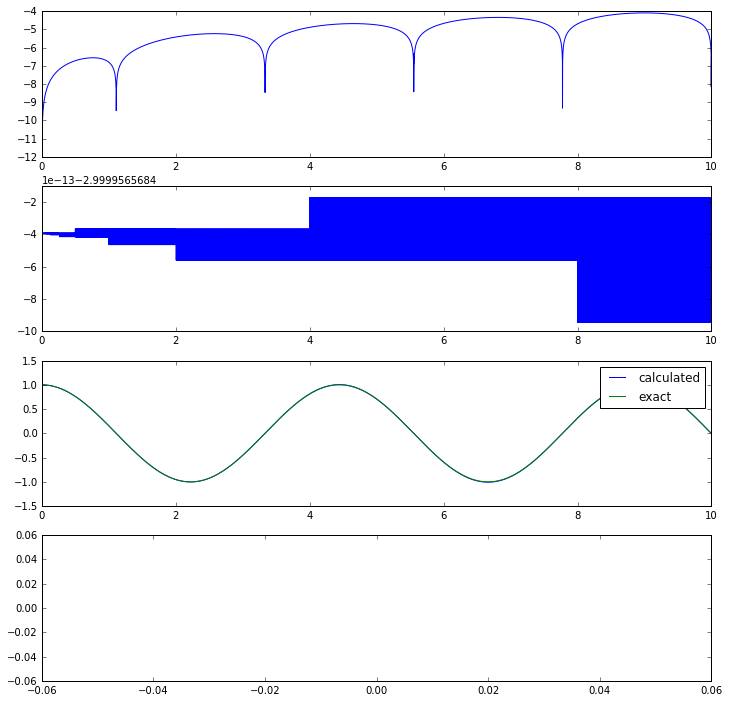

In [17]:
plot_results_for(simple_euler);

In [ ]:
x, y, errs = ArrayMethod(R38_Y, R38_X, 3, constant_h = 1e-4).method(f, F0, X0, XF)

In [ ]:
plot(x, F(x)),
xs = np.linspace(X0, XF)
plot(xs, F(xs))
plot(x, [F(i) for i in x])
plot(x, y[0])

....................................................................................................|


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


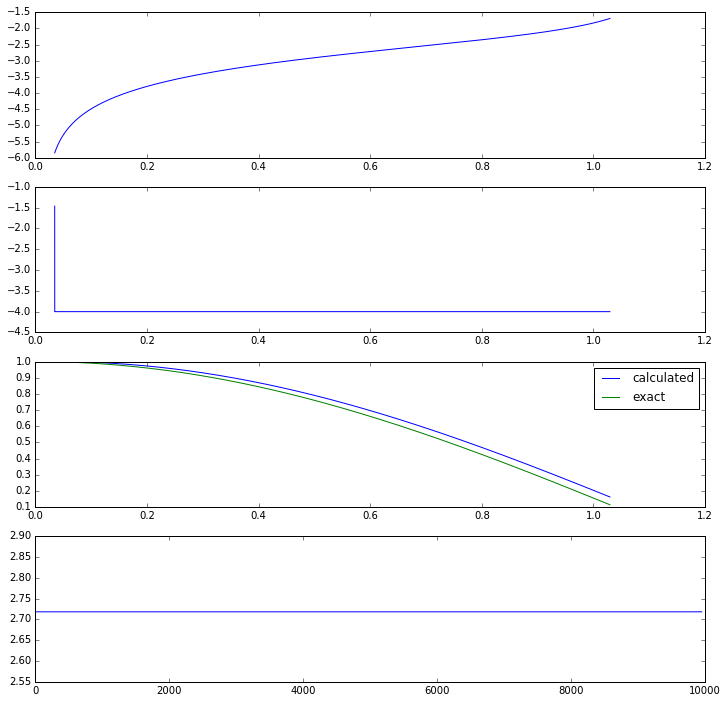

In [18]:
plot_results_for(ArrayMethod(R38_Y, R38_X, 3).method);

In [ ]:
plot_results_for(ArrayMethod(MERSON_Y, MERSON_X, 4).method);

In [ ]:
plot_results_for(ArrayMethod(VERNER_Y, VERNER_X, 5).method);